In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

class ReducedRankRegression(nn.Module):
    def __init__(self, p, q, r):
        """
        :param p: Number of predictors
        :param q: Number of responses
        :param r: Reduced rank
        """
        super(ReducedRankRegression, self).__init__()
        # self.W = nn.Parameter(torch.randn(p, r))
        # self.C = nn.Parameter(torch.randn(r, q))

        self.W = torch.ones((p,r))
        self.W.requires_grad_(True)  
        # nn.Parameter(torch.randn(p, r))
        # self.C = nn.Parameter(torch.randn(r, q))
        self.C = torch.ones((r,q))
        self.C.requires_grad_(True)
    
    def forward(self, X):
        return X @ self.W @ self.C

# # Example usage
# if __name__ == "__main__":
#     # Generate random data for demonstration
#     n_samples = 100
#     n_predictors = 10
#     n_responses = 5
#     rank = 3
    
#     X = torch.randn(n_samples, n_predictors)
#     Y = torch.randn(n_samples, n_responses)
    
#     # Define the model
#     model = ReducedRankRegression(n_predictors, n_responses, rank)
    
#     # Define the loss function and optimizer
#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.01)
    
#     # Training loop
#     n_epochs = 500
#     for epoch in range(n_epochs):
#         model.train()
        
#         # Forward pass
#         Y_pred = model(X)
        
#         # Compute loss
#         loss = criterion(Y_pred, Y)
        
#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         if (epoch+1) % 50 == 0:
#             print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')
    
#     print("Training complete.")

In [2]:
# Load the data
import pickle
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as netcdf

with open('ssp585_time_series.pkl', 'rb') as f:
    dic_ssp585 = pickle.load(f)

In [3]:
import os 

# Get the list of all files and directories
path = "/net/atmos/data/cmip6-ng/tos/ann/g025"
dir_list = os.listdir(path)

print("Files and directories in '", path, "' :")

list_model = []
list_forcing = []

for idx, file in enumerate(dir_list):

    file_split = file.split("_")
    
    # extract model names
    model_name = file_split[2]
    forcing = file_split[3]
    run_name = file_split[4]
    
    list_model.append(model_name)
    list_forcing.append(forcing)
    
model_names = list(set(list_model))
forcing_names = list(set(list_forcing))

Files and directories in ' /net/atmos/data/cmip6-ng/tos/ann/g025 ' :


In [4]:
import netCDF4 as netcdf

# define the file
file = '/net/h2o/climphys3/simondi/cope-analysis/data/erss/sst_annual_g050_mean_19812014_centered.nc'

# read the dataset
file2read = netcdf.Dataset(file,'r')

# load longitude, latitude and sst monthly means
lon = np.array(file2read.variables['lon'][:])
lat = np.array(file2read.variables['lat'][:])
sst = np.array(file2read.variables['sst'])

# define grid
lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')

time_period = 33
grid_lat_size = lat.shape[0]
grid_lon_size = lon.shape[0]

In [5]:
import skimage

# first filter out the models that do not contain ensemble members 
dic_reduced_ssp585 = {}

for m in list(dic_ssp585.keys()):
    if len(dic_ssp585[m].keys()) > 2:
        dic_reduced_ssp585[m] = dic_ssp585[m].copy()
        for idx_i, i in enumerate(dic_ssp585[m].keys()):
            dic_reduced_ssp585[m][i] = skimage.transform.downscale_local_mean(dic_reduced_ssp585[m][i],(1,2,2))
            lat_size = dic_reduced_ssp585[m][i][0,:,:].shape[0]
            lon_size = dic_reduced_ssp585[m][i][0,:,:].shape[1]

In [6]:
nan_idx = []
for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    for idx_i,i in enumerate(dic_reduced_ssp585[m].keys()):    
        # for t in enumerate(range(time_period)[:2]):
            # print(np.where(np.isnan(dic_reduced_ssp585[m][i][t,:,:].ravel())==True))
        nan_idx_tmp = list(np.where(np.isnan(dic_reduced_ssp585[m][i][0,:,:].ravel())==True)[0])
        # nan_idx_tmp_tt = list(np.where(np.isnan(dic_reduced_ssp585[m][i][1,:,:].ravel())==True)[0])
        
        nan_idx = list(set(nan_idx) | set(nan_idx_tmp))

notnan_idx = list(set(list(range(lon_size*lat_size))) - set(nan_idx))

In [7]:
# second, for each model we compute the anomalies 
dic_processed_ssp585 = {}

import numpy as np

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_processed_ssp585[m] = dic_reduced_ssp585[m].copy()
    
    mean_ref_ensemble = 0
    for idx_i, i in enumerate(dic_reduced_ssp585[m].keys()):
        y_tmp = dic_reduced_ssp585[m][i][131:164,:,:].copy().reshape(time_period, lat_size*lon_size)
        y_tmp[:,nan_idx] = float('nan')
        
        
        if idx_i == 0:
            mean_ref_ensemble = np.nanmean(y_tmp,axis=0)/ len(dic_reduced_ssp585[m].keys())
        else:
            mean_ref_ensemble += np.nanmean(y_tmp,axis=0)/ len(dic_reduced_ssp585[m].keys())

    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        dic_processed_ssp585[m][i] = y_tmp - mean_ref_ensemble

/tmp/ipykernel_41664/3205467388.py:16: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(y_tmp,axis=0)/ len(dic_reduced_ssp585[m].keys())
/tmp/ipykernel_41664/3205467388.py:18: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble += np.nanmean(y_tmp,axis=0)/ len(dic_reduced_ssp585[m].keys())


In [8]:
# compute the forced response
dic_forced_response_ssp585 = dict({})
dic_forced_response_ssp585_tmp = {}

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_forced_response_ssp585[m] = dic_reduced_ssp585[m].copy()
    dic_forced_response_ssp585_tmp[m] = dic_reduced_ssp585[m].copy()

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        y_tmp = dic_reduced_ssp585[m][i][131:164,:,:].copy().reshape(time_period, lat_size*lon_size)
        y_tmp[:,nan_idx] = float('nan')

        if idx_i == 0:
            mean_spatial_ensemble = y_tmp/ len(dic_forced_response_ssp585[m].keys())
        else:
            mean_spatial_ensemble += y_tmp/ len(dic_forced_response_ssp585[m].keys())

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):        
        dic_forced_response_ssp585[m][i] = mean_spatial_ensemble - np.nanmean(mean_spatial_ensemble)
    dic_forced_response_ssp585_tmp[m] = mean_spatial_ensemble - np.nanmean(mean_spatial_ensemble)

In [9]:
y_forced_response = {}
x_predictor = {}

for idx_m,m in enumerate(dic_processed_ssp585.keys()):
    y_forced_response[m] = {}
    x_predictor[m] = {}

    y_forced_response[m] = dic_forced_response_ssp585_tmp[m]
    
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        x_predictor[m][i] = dic_processed_ssp585[m][i]
        x_predictor[m][i][:,nan_idx] = float('nan')

In [1]:
y_forced_response_concatenate = {}
x_predictor_concatenate = {}
count_x = 0


for idx_m,m in enumerate(dic_processed_ssp585.keys()):
    y_forced_response_concatenate[m] = 0
    x_predictor_concatenate[m] = 0

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        count_x += len(dic_processed_ssp585[m].keys())*33
        
        if idx_i ==0:
            y_forced_response_concatenate[m] = dic_forced_response_ssp585[m][i]
            x_predictor_concatenate[m] = dic_processed_ssp585[m][i]
        else:
            y_forced_response_concatenate[m] = np.concatenate([y_forced_response_concatenate[m],dic_forced_response_ssp585[m][i]])
            x_predictor_concatenate[m] = np.concatenate([x_predictor_concatenate[m], dic_processed_ssp585[m][i]],axis=0)  
    x_predictor_concatenate[m][:,nan_idx] = float('nan')
    y_forced_response_concatenate[m][:,nan_idx] = float('nan')

NameError: name 'dic_processed_ssp585' is not defined

In [11]:
# compute the variance
# variance_processed_ssp585 = {}
# std_processed_ssp585 = {}
# for idx_m,m in enumerate(x_predictor.keys()):
#     variance_processed_ssp585[m] = {}
#     arr_tmp = np.zeros((len(x_predictor[m].keys()),33))
    
#     for idx_i, i in enumerate(list(x_predictor[m].keys())):
#         arr_tmp[idx_i,:] = np.nanmean(x_predictor[m][i],axis=1)

#     arr_tmp_values = np.zeros((len(x_predictor[m].keys()),33))
#     for idx_i, i in enumerate(x_predictor[m].keys()):
#         arr_tmp_values[idx_i,:] = (y_forced_response[m][i] - arr_tmp[idx_i,:])**2

#     # variance_processed_ssp585[m] = torch.nanmean(torch.from_numpy(arr_tmp_values),axis=0)
#     variance_processed_ssp585[m] = torch.mean(torch.nanmean(torch.from_numpy(arr_tmp_values),axis=0))
    # variance_processed_ssp585[m] = torch.tensor(1.0)

In [12]:
# Data preprocessing
x_train = {}
y_train = {}

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    x_train[m] = torch.nan_to_num(torch.from_numpy(x_predictor_concatenate[m])).to(torch.float64)
    y_train[m] = torch.nan_to_num(torch.from_numpy(y_forced_response[m])).to(torch.float64)

In [32]:
# We want X in R^{grid x runs*time steps}
x_tmp = torch.zeros(count_x, lat_size*lon_size)
y_tmp = torch.zeros(count_x, lat_size*lon_size)

m0 = 'KACE-1-0-G'
x_test = torch.zeros(len(x_predictor[m0].keys())*33, lat_size*lon_size)
y_test = torch.zeros(len(x_predictor[m0].keys())*33, lat_size*lon_size)

count_tmp =0

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    if m != 'KACE-1-0-G':

        if count_tmp ==0:
            x_tmp[:x_train[m].shape[0],:] = x_train[m]
            y_tmp[:y_train[m].shape[0],:] = y_train[m]
            count_tmp = x_train[m].shape[0]
    
        else:
            x_tmp[count_tmp:count_tmp+x_train[m].shape[0],:] = x_train[m]
            y_tmp[count_tmp:count_tmp+y_train[m].shape[0],:] = y_train[m]
            count_tmp = x_train[m].shape[0]

    else: 
        x_test = x_train[m]
        for idx_i, i in enumerate(x_predictor[m].keys()):
            y_test[idx_i*33:(idx_i+1)*33,:] = y_train[m]

In [ ]:
n_samples = count_x
n_predictors = lat_size*lon_size
n_responses = lat_size*lon_size
rank = 1000

lambda_ = 10.0

# Define the model
model = ReducedRankRegression(n_predictors, n_responses, rank)
    
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam([model.W,model.C], lr=0.01)
    
# Training loop
n_epochs = 200
for epoch in range(n_epochs):
    model.train()
        
    # Forward pass
    y_pred = model(x_tmp)
        
    # Compute loss
    loss = criterion(y_pred,y_tmp) + lambda_*torch.norm(torch.matmul(model.W,model.C),p='fro')
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
    if (epoch+1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')
        print(torch.mean((y_pred - y_tmp)**2))
    
print("Training complete.")

Epoch [2/200], Loss: 151682960.0000
tensor(31249064., grad_fn=<MeanBackward0>)
Epoch [4/200], Loss: 139568528.0000
tensor(26455196., grad_fn=<MeanBackward0>)
Epoch [6/200], Loss: 127995280.0000
tensor(22246322., grad_fn=<MeanBackward0>)
Epoch [8/200], Loss: 116989152.0000
tensor(18576382., grad_fn=<MeanBackward0>)
Epoch [10/200], Loss: 106480096.0000
tensor(15399254., grad_fn=<MeanBackward0>)
Epoch [12/200], Loss: 96580176.0000
tensor(12669134., grad_fn=<MeanBackward0>)
Epoch [14/200], Loss: 87271128.0000
tensor(10341274., grad_fn=<MeanBackward0>)
Epoch [16/200], Loss: 78527248.0000
tensor(8372387.5000, grad_fn=<MeanBackward0>)
Epoch [18/200], Loss: 70346472.0000
tensor(6721000., grad_fn=<MeanBackward0>)
Epoch [20/200], Loss: 62757832.0000
tensor(5347880., grad_fn=<MeanBackward0>)
Epoch [22/200], Loss: 55725076.0000
tensor(4216415.5000, grad_fn=<MeanBackward0>)
Epoch [24/200], Loss: 49240924.0000
tensor(3292757.2500, grad_fn=<MeanBackward0>)
Epoch [26/200], Loss: 43301004.0000
tensor(2

In [52]:
model.W = model.W.to(torch.float64)
model.C = model.C.to(torch.float64)

In [55]:
M  = torch.matmul(model.W.detach(), model.C.detach())
# MX = torch.matmul(x_test[10,:], M)
MX = model.C[10,:].detach()

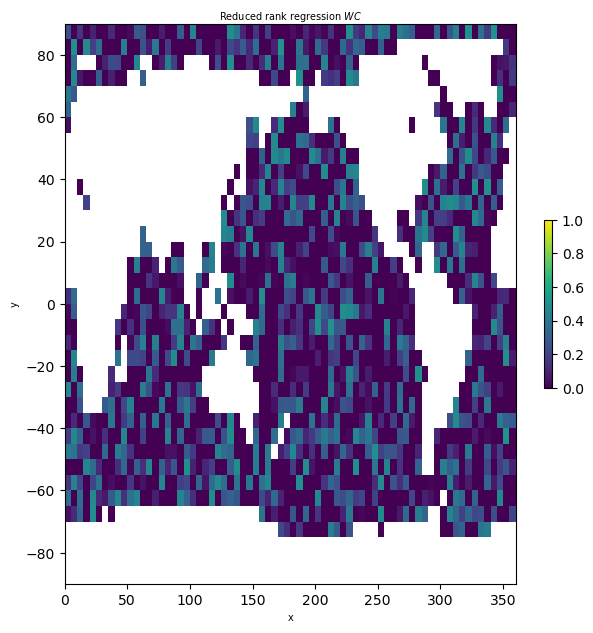

In [58]:
# define beta to plot
M_tmp = MX.detach().clone()
M_tmp[nan_idx] = float('nan')
M_tmp = M_tmp.detach().numpy().reshape(lat_size,lon_size)

# define robust beta
# beta_robust_tmp = beta_robust.detach().clone()
# beta_robust_tmp[nan_idx] = float('nan')
# beta_robust_tmp = beta_robust_tmp.detach().numpy().reshape(lat.shape[0],lon.shape[0])

fig0 = plt.figure(figsize=(16,16))           

ax0 = fig0.add_subplot(2, 2, 1)        
ax0.set_title(r'Reduced rank regression $WC$', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,M_tmp,vmin=-0.00,vmax = 1.0)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

# ax1 = fig0.add_subplot(2, 2, 2)        
# ax1.set_title(r'Robust regression coefficient $\beta_{\mathrm{rob}}$', size=7,pad=3.0)
# im1 = ax1.pcolormesh(lon_grid,lat_grid,beta_robust_tmp,vmin=-0.00,vmax = 0.001)
# plt.colorbar(im1, ax=ax1, shrink=0.3)
# ax1.set_xlabel(r'x', size=7)
# ax1.set_ylabel(r'y', size=7)

plt.show()